In [1]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import tensorflow as tf
print("TensorFlow version: ",tf.version.VERSION)

import pandas as pd
import numpy as np
import urllib
import json
import datetime

from utils import get_daily_demand_data, plot_series
import os

TensorFlow version:  2.3.4


In [2]:
!pip install --user google-cloud-bigquery==1.25.0

     |████████████████████████████████| 169 kB 7.3 MB/s eta 0:00:01
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-cloud-storage 1.42.0 requires google-resumable-media<3.0dev,>=1.3.0; python_version >= "3.6", but you have google-resumable-media 0.5.1 which is incompatible.


In [3]:
# Change with your own bucket and project below:
BUCKET =  "qwiklabs-gcp-04-388cc7c94158"
PROJECT = BUCKET

OUTDIR = "gs://{bucket}/demand/data/".format(bucket=BUCKET)

os.environ['BUCKET'] = BUCKET
os.environ['OUTDIR'] = OUTDIR
os.environ['PROJECT'] = PROJECT

In [5]:
start_date = '2019-04-01'
end_date = '2020-03-31' 

NORM_VALUE = 1e6 # divided all values normalization

values, times = get_daily_demand_data(start_date, end_date, write_json=False)
values = values / NORM_VALUE

dataset = pd.DataFrame({'times': times, 'values': values})
dataset.to_csv("data/dataset.csv", index=False)

In [42]:
start_date = '2020-04-01'
end_date = '2020-06-30' 

NORM_VALUE = 1e6 # divided all values normalization

values_eval, times_eval = get_daily_demand_data(start_date, end_date, write_json=False)
values_eval = values_eval / NORM_VALUE

dataset = pd.DataFrame({'times': times_eval, 'values': values_eval})
dataset.to_csv("data/dataset_eval.csv", index=False)

(366,) (91,)


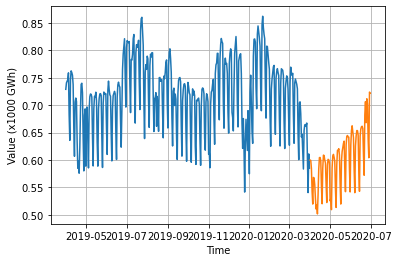

In [7]:
plot_series(times, values)
plot_series(times_eval, values_eval)

print(values.shape, values_eval.shape)

## Create BQ Dataset

In [ ]:
# https://github.com/GoogleCloudPlatform/training-data-analyst/blob/master/courses/machine_learning/deepdive2/feature_engineering/labs/1_bqml_basic_feat_eng_bqml-lab.ipynb

In [4]:
%%bash
# Create a BigQuery dataset

# !gsutil cp -r data OUTDIR

datasetexists=$(bq ls -d | grep -w demand_pred)

if [ -n "$datasetexists" ]; then
    echo -e "BigQuery dataset already exists, let's not recreate it."

else
    echo "Creating BigQuery dataset"
    
    bq --location=US mk --dataset \
        --description 'Demand prediction' \
        $PROJECT:demand_pred
   echo "Here are your current datasets:"
   bq ls
fi

Creating BigQuery dataset
Dataset 'qwiklabs-gcp-04-388cc7c94158:demand_pred' successfully created.
Here are your current datasets:
   datasetId   
 ------------- 
  demand_pred  


In [5]:
%%bash

bq load --autodetect \
        --location=US \
        --source_format=CSV \
        $PROJECT:demand_pred.dataset \
        data/dataset.csv 

Upload complete.
Waiting on bqjob_r1dcb195159e420d8_0000017bd5212514_1 ... (1s) Current status: DONE   


In [6]:
%%bash

bq load --autodetect \
        --location=US \
        --source_format=CSV \
        $PROJECT:demand_pred.dataset_eval \
        data/dataset_eval.csv 

Upload complete.
Waiting on bqjob_r28c83ce3db1e8cc9_0000017bd52137a2_1 ... (1s) Current status: DONE   


In [7]:
%%bigquery
 
SELECT times, values, EXTRACT(DAYOFWEEK FROM times) as dow
FROM
  demand_pred.dataset

Downloading: 100%|██████████| 366/366 [00:01<00:00, 225.46rows/s]


,times,values,dow
0,2019-04-01,0.728854,2
1,2019-04-02,0.740720,3
2,2019-04-03,0.743726,4
3,2019-04-04,0.746532,5
4,2019-04-05,0.758884,6
...,...,...,...
361,2020-03-27,0.667336,6
362,2020-03-28,0.605617,7
363,2020-03-29,0.540515,1
364,2020-03-30,0.610996,2


## Create Arima Model!

In [12]:
%%bigquery

CREATE OR REPLACE MODEL
    demand_pred.baseline_arima_model 
    OPTIONS(MODEL_TYPE='ARIMA_PLUS',
         time_series_timestamp_col='times',
         time_series_data_col='values',
         auto_arima = TRUE,
         data_frequency = 'AUTO_FREQUENCY',
         decompose_time_series = TRUE) AS
SELECT
  times,
  values
FROM
  demand_pred.dataset

Query complete after 0.00s: 100%|██████████| 3/3 [00:00<00:00, 1468.77query/s]                        


""


In [14]:
%%bigquery

SELECT *
FROM
  ML.ARIMA_EVALUATE(MODEL `demand_pred.baseline_arima_model`, STRUCT(FALSE AS show_all_candidate_models))

Downloading: 100%|██████████| 1/1 [00:01<00:00,  1.30s/rows]


,non_seasonal_p,non_seasonal_d,non_seasonal_q,has_drift,log_likelihood,AIC,variance,seasonal_periods,has_holiday_effect,has_spikes_and_dips,has_step_changes,error_message
0,2,0,1,False,958.419448,-1906.838896,0.000153,[WEEKLY],False,False,False,


In [16]:
%%bigquery

# forecast with arima model

SELECT *
FROM
  (SELECT * 
   FROM ML.FORECAST(MODEL demand_pred.baseline_arima_model,
              STRUCT(1 AS horizon, 0.4 AS confidence_level))),
    (SELECT times, values 
     FROM demand_pred.dataset_eval)
    

Downloading: 100%|██████████| 91/91 [00:01<00:00, 54.73rows/s]


,forecast_timestamp,forecast_value,standard_error,confidence_level,prediction_interval_lower_bound,prediction_interval_upper_bound,confidence_interval_lower_bound,confidence_interval_upper_bound,times,values
0,2020-04-01 00:00:00+00:00,0.735166,0.0,0.4,0.735166,0.735166,0.735166,0.735166,2020-04-05,0.519594
1,2020-04-01 00:00:00+00:00,0.735166,0.0,0.4,0.735166,0.735166,0.735166,0.735166,2020-06-10,0.653633
2,2020-04-01 00:00:00+00:00,0.735166,0.0,0.4,0.735166,0.735166,0.735166,0.735166,2020-05-30,0.583380
3,2020-04-01 00:00:00+00:00,0.735166,0.0,0.4,0.735166,0.735166,0.735166,0.735166,2020-06-19,0.657173
4,2020-04-01 00:00:00+00:00,0.735166,0.0,0.4,0.735166,0.735166,0.735166,0.735166,2020-06-23,0.706422
...,...,...,...,...,...,...,...,...,...,...
86,2020-04-01 00:00:00+00:00,0.735166,0.0,0.4,0.735166,0.735166,0.735166,0.735166,2020-05-07,0.604624
87,2020-04-01 00:00:00+00:00,0.735166,0.0,0.4,0.735166,0.735166,0.735166,0.735166,2020-05-11,0.591351
88,2020-04-01 00:00:00+00:00,0.735166,0.0,0.4,0.735166,0.735166,0.735166,0.735166,2020-05-24,0.542171
89,2020-04-01 00:00:00+00:00,0.735166,0.0,0.4,0.735166,0.735166,0.735166,0.735166,2020-06-14,0.542807


## windowing with BQ

In [50]:
%%bigquery

CREATE OR REPLACE TABLE demand_pred.dataset_wtrain
AS
(
SELECT times, values, EXTRACT(DAYOFWEEK FROM times) as dow,
    LAG(values) OVER (ORDER BY times ASC) values_1,
    LAG(values,2) OVER (ORDER BY times ASC) values_2,
    LAG(values,3) OVER (ORDER BY times ASC) values_3,
    LAG(values,4) OVER (ORDER BY times ASC) values_4,
    LAG(values,5) OVER (ORDER BY times ASC) values_5,
    LAG(values,6) OVER (ORDER BY times ASC) values_6,
    LAG(values,7) OVER (ORDER BY times ASC) values_7,
    LAG(values,8) OVER (ORDER BY times ASC) values_8,
    LAG(values,9) OVER (ORDER BY times ASC) values_9,
    LAG(values,10) OVER (ORDER BY times ASC) values_10,
    LAG(values,11) OVER (ORDER BY times ASC) values_11,
    LAG(values,12) OVER (ORDER BY times ASC) values_12,
    LAG(values,13) OVER (ORDER BY times ASC) values_13,
    LAG(values,14) OVER (ORDER BY times ASC) values_14,
    LAG(values,15) OVER (ORDER BY times ASC) values_15,
    LAG(values,16) OVER (ORDER BY times ASC) values_16,
    LAG(values,17) OVER (ORDER BY times ASC) values_17,
    LAG(values,18) OVER (ORDER BY times ASC) values_18,
    LAG(values,19) OVER (ORDER BY times ASC) values_19,
    LAG(values,20) OVER (ORDER BY times ASC) values_20,
 
FROM demand_pred.dataset
ORDER BY times ASC
)

Query complete after 0.00s: 100%|██████████| 2/2 [00:00<00:00, 1066.17query/s]                        


""


## Create Model!

In [51]:
%%bigquery

CREATE OR REPLACE MODEL
    demand_pred.baseline_lr_hpmodel 
    OPTIONS(
        NUM_TRIALS = 4,
        MODEL_TYPE = 'LINEAR_REG',
        MAX_ITERATIONS = 5,
        LS_INIT_LEARN_RATE = 0.15,
        L1_REG = HPARAM_RANGE(0, 1),
        HPARAM_TUNING_OBJECTIVES = ['MEAN_ABSOLUTE_ERROR'],
        DATA_SPLIT_METHOD = 'SEQ',
        DATA_SPLIT_EVAL_FRACTION = 0.3,
        DATA_SPLIT_COL = 'times'
        )
    AS
SELECT
  times, values AS label, dow, values_1, values_2, values_3, values_4, values_5, values_6, values_7, values_8,values_9, values_10,
    values_11, values_12, values_13, values_14, values_15, values_16, values_17, values_18,values_19, values_20

FROM
  demand_pred.dataset_wtrain

Query complete after 0.00s: 100%|██████████| 9/9 [00:00<00:00, 5277.33query/s]                        


""


In [52]:
%%bigquery

SELECT * FROM ML.EVALUATE(MODEL demand_pred.baseline_lr_hpmodel)

Downloading: 100%|██████████| 4/4 [00:01<00:00,  2.43rows/s]


,trial_id,mean_absolute_error,mean_squared_error,mean_squared_log_error,median_absolute_error,r2_score,explained_variance
0,1,0.132929,0.018573,0.007258,0.130149,-3.993504,0.757139
1,2,0.132927,0.018573,0.007258,0.130150,-3.993311,0.757199
2,3,0.132929,0.018573,0.007258,0.130149,-3.993504,0.757138
3,4,0.132929,0.018573,0.007258,0.130149,-3.993504,0.757138


In [54]:
from google.cloud import bigquery

bqclient = bigquery.Client()

predict_query = bqclient.query("""
    SELECT times, predicted_label
    FROM
      ML.PREDICT(MODEL demand_pred.baseline_lr_hpmodel,
        (
        SELECT
            times, EXTRACT(DAYOFWEEK FROM times) as dow,
            LAG(values) OVER (ORDER BY times ASC) values_1,
            LAG(values,2) OVER (ORDER BY times ASC) values_2,
            LAG(values,3) OVER (ORDER BY times ASC) values_3,
            LAG(values,4) OVER (ORDER BY times ASC) values_4,
            LAG(values,5) OVER (ORDER BY times ASC) values_5,
            LAG(values,6) OVER (ORDER BY times ASC) values_6,
            LAG(values,7) OVER (ORDER BY times ASC) values_7,
            LAG(values,8) OVER (ORDER BY times ASC) values_8,
            LAG(values,9) OVER (ORDER BY times ASC) values_9,
            LAG(values,10) OVER (ORDER BY times ASC) values_10,
            LAG(values,11) OVER (ORDER BY times ASC) values_11,
            LAG(values,12) OVER (ORDER BY times ASC) values_12,
            LAG(values,13) OVER (ORDER BY times ASC) values_13,
            LAG(values,14) OVER (ORDER BY times ASC) values_14,
            LAG(values,15) OVER (ORDER BY times ASC) values_15,
            LAG(values,16) OVER (ORDER BY times ASC) values_16,
            LAG(values,17) OVER (ORDER BY times ASC) values_17,
            LAG(values,18) OVER (ORDER BY times ASC) values_18,
            LAG(values,19) OVER (ORDER BY times ASC) values_19,
            LAG(values,20) OVER (ORDER BY times ASC) values_20,
        FROM demand_pred.dataset_eval
        ORDER BY TIMES
        )) ORDER BY TIMES
        """)


predictions = predict_query.to_dataframe()
predictions.head(3)

,times,predicted_label
0,2020-04-01,0.572771
1,2020-04-02,0.540425
2,2020-04-03,0.529153


In [55]:
from sklearn.metrics import mean_absolute_percentage_error
mean_absolute_percentage_error(values_eval, predictions.predicted_label)

0.496307932848271